Import Libraries

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

#Loading dataset

In [ ]:
BATCH_SIZE = 64

In [ ]:
train_dataset = datasets.FashionMNIST(
    root="dataset/", train=True, download=True, transform=transforms.ToTensor()
)
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, (50000, 10000)
)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = datasets.FashionMNIST(
    root="dataset/", train=False, download=True, transform=transforms.ToTensor()
)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
print(f"{len(train_loader.dataset)}")
print(f"{len(val_loader.dataset)}")
print(f"{len(test_loader.dataset)}")

50000
10000
10000


#Define model

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size: int, n_classes: int) -> None:
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
input_size = 28 * 28
num_classes = len(test_dataset.classes)
learning_rate = 0.001
EPOCHS = 15

In [ ]:
model = SimpleMLP(input_size, num_classes).to(device)

##Define loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

##Train model

## Utility Functions

In [23]:
def validation(
    model: torch.nn.modules.module,
    val_loader: torch.utils.data.dataloader,
    loss_fn: torch.nn.modules.loss,
) -> float:
    """
    compute validation loss with corresponding model and loss function
    return validation loss
    """

    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, targets in tqdm(val_loader, desc="Validation"):
            data = data.to(device)
            targets = targets.to(device)

            data = data.reshape(data.shape[0], -1)

            scores = model(data)

            loss = loss_fn(scores, targets)
            total_loss += loss.item()

    return total_loss / len(val_loader)

In [16]:
def training(
    model: torch.nn.modules.module,
    train_dataset: torch.utils.data.dataloader,
    val_dataset: torch.utils.data.dataloader,
    criterion: torch.nn.modules.loss,
    optimizer: torch.optim,
    epochs: int = 5,
) -> tuple:

    """
    train model with given train set and optimizer
    return train and validation losses
    """
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs)):
        for data, targets in tqdm(train_dataset, desc=f"Epoch {epoch + 1}"):
            # convert data and target to device
            data = data.to(device)
            targets = targets.to(device)
            # flatten data to shape 28* 28
            data = data.reshape(data.shape[0], -1)

            # forward pass
            scores = model(data)
            loss = criterion(scores, targets)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()

        # validation
        val_loss = validation(model, val_dataset, criterion)
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        print(f"Train Loss: {np.mean(train_losses):.2f}, ", end="")
        print(f"Validation Loss: {np.mean(val_losses):.2f}")

    return train_losses, val_losses

In [17]:
def inference(
    model: torch.nn.modules.module, test_dataset: torch.utils.data.dataloader
) -> float:

    """
    inference model on test set
    return test accuracy
    """

    n_samples = 0
    n_correct = 0
    model.eval()

    with torch.no_grad():
        for data, targets in tqdm(test_dataset):
            data = data.to(device)
            targets = targets.to(device)

            data = data.reshape(data.shape[0], -1)

            scores = model(data)
            _, preds = scores.max(1)
            n_correct += (preds == targets).sum().item()
            n_samples += targets.size(0)

        return n_correct / n_samples

In [18]:
def print_acc(acc: float, train: bool = True) -> None:
    """
    print accuracy in appropriate format
    """
    if train:
        print(f"Train Accuracy: {acc * 100:.2f}%")
    else:
        print(f"Test Accuracy: {acc * 100:.2f}%")

In [19]:
def plot(train_loss: list, val_loss: list) -> None:
    """
    plotting train and validation losses
    """
    epochs = list(range(1, len(train_loss) + 1))

    plt.plot(epochs, train_loss, label="train loss")
    plt.plot(epochs, val_loss, label="validation loss")
    plt.xlabel("# epochs")
    plt.xticks(epochs)
    plt.ylabel("loss")
    plt.legend()
    # fig, ax = plt.subplots(1,2,figsize =(12,5))

    # ax[0].plot(epochs,train_loss)
    # ax[0].set_title('training loss')
    # ax[0].set(xlabel = '# epochs', ylabel = 'loss' )

    # ax[1].plot(epochs,val_loss)
    # ax[1].set_title('validation loss')
    # ax[1].set(xlabel = '# epochs', ylabel = 'loss' )

    plt.show()

In [ ]:
train_losses, val_losses = training(
    model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.14, Validation Loss: 0.48


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.59, Validation Loss: 0.46


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.50, Validation Loss: 0.43


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.51, Validation Loss: 0.42


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.45, Validation Loss: 0.41


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.44, Validation Loss: 0.40


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.40, Validation Loss: 0.39


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.39, Validation Loss: 0.38


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.36, Validation Loss: 0.37


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.36, Validation Loss: 0.37


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.36, Validation Loss: 0.37


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.36, Validation Loss: 0.36


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.34, Validation Loss: 0.36


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.33, Validation Loss: 0.36


Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.32, Validation Loss: 0.36


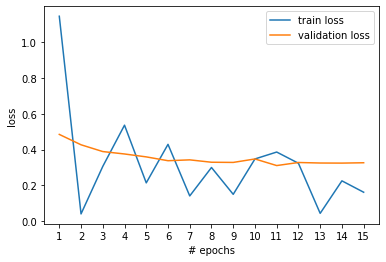

In [ ]:
plot(train_losses, val_losses)

In [ ]:
train_acc = inference(model, train_loader)
print_acc(train_acc)

  0%|          | 0/782 [00:00<?, ?it/s]

Train Accuracy: 91.69%


In [ ]:
test_acc = inference(model, test_loader)
print_acc(test_acc, train=False)

  0%|          | 0/157 [00:00<?, ?it/s]

Test Accuracy: 88.02%


## Second Model

In [ ]:
class BigMLP(nn.Module):
    def __init__(self, input_size: int, n_classes: int) -> None:
        super(BigMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
big_mlp = BigMLP(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(big_mlp.parameters(), lr=learning_rate)

In [ ]:
train_losses, val_losses = training(
    big_mlp, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.25, Validation Loss: 0.43


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.46, Validation Loss: 0.41


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.57, Validation Loss: 0.39


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.54, Validation Loss: 0.38


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.52, Validation Loss: 0.37


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.51, Validation Loss: 0.36


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.45, Validation Loss: 0.36


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.43, Validation Loss: 0.35


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.41, Validation Loss: 0.35


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.40, Validation Loss: 0.35


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.39, Validation Loss: 0.34


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.40, Validation Loss: 0.34


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.38, Validation Loss: 0.34


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.38, Validation Loss: 0.34


Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.36, Validation Loss: 0.34


In [ ]:
train_acc = inference(big_mlp, train_loader)
print_acc(train_acc)

  0%|          | 0/782 [00:00<?, ?it/s]

Train Accuracy: 91.97%


In [ ]:
test_acc = inference(big_mlp, test_loader)
print_acc(test_acc, train=False)

  0%|          | 0/157 [00:00<?, ?it/s]

Test Accuracy: 87.21%


## Third Model

In [ ]:
class BiggerMLP(nn.Module):
    def __init__(self, input_size: int, n_classes: int) -> None:
        super(BiggerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
bigger_mlp = BiggerMLP(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bigger_mlp.parameters(), lr=learning_rate)

In [ ]:
train_losses, val_losses = training(
    bigger_mlp, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.63, Validation Loss: 0.46


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.49, Validation Loss: 0.43


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.46, Validation Loss: 0.41


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.42, Validation Loss: 0.40


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.42, Validation Loss: 0.39


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.40, Validation Loss: 0.38


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.36, Validation Loss: 0.37


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.37, Validation Loss: 0.37


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.36, Validation Loss: 0.37


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.36, Validation Loss: 0.36


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.36, Validation Loss: 0.36


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.35, Validation Loss: 0.36


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.35, Validation Loss: 0.35


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.33, Validation Loss: 0.35


Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.34, Validation Loss: 0.35


In [ ]:
train_acc = inference(bigger_mlp, train_loader)
print_acc(train_acc)

  0%|          | 0/782 [00:00<?, ?it/s]

Train Accuracy: 92.20%


In [ ]:
test_acc = inference(bigger_mlp, test_loader)
print_acc(test_acc, train=False)

  0%|          | 0/157 [00:00<?, ?it/s]

Test Accuracy: 88.06%


#Dropout

In [ ]:
class MLP_Dropout(nn.Module):
    def __init__(self, input_size: int, n_classes: int) -> None:
        super(MLP_Dropout, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [ ]:
dropout_model = MLP_Dropout(input_size, num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dropout_model.parameters(), lr=learning_rate)

In [ ]:
train_losses, val_losses = training(
    dropout_model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.58, Validation Loss: 0.47


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.59, Validation Loss: 0.43


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.49, Validation Loss: 0.42


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.47, Validation Loss: 0.40


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.41, Validation Loss: 0.39


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.37, Validation Loss: 0.38


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.42, Validation Loss: 0.37


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.39, Validation Loss: 0.37


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.38, Validation Loss: 0.36


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.38, Validation Loss: 0.36


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.41, Validation Loss: 0.36


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.40, Validation Loss: 0.35


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.38, Validation Loss: 0.35


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.37, Validation Loss: 0.35


Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.35, Validation Loss: 0.35


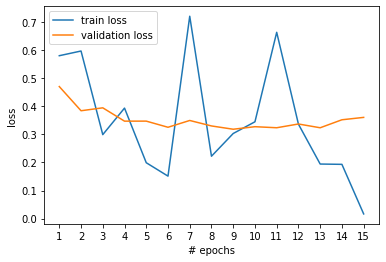

In [ ]:
plot(train_losses, val_losses)

In [ ]:
train_acc = inference(dropout_model, train_loader)
print_acc(train_acc)

  0%|          | 0/782 [00:00<?, ?it/s]

Train Accuracy: 91.55%


In [ ]:
test_acc = inference(dropout_model, test_loader)
print_acc(test_acc)

  0%|          | 0/157 [00:00<?, ?it/s]

Train Accuracy: 87.62%


#Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(
        self,
        patience: int = 5,
    ) -> None:

        self.patience = patience
        self.counter = 0
        self.min_loss = np.inf
        self.early_stop = False

    def __call__(self, loss):
        if loss < self.min_loss:
            self.min_loss = loss
            self.counter = 0
        elif loss > self.min_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [21]:
def training_with_early_stopping(
    model: torch.nn.modules.module,
    train_dataset: torch.utils.data.dataloader,
    val_dataset: torch.utils.data.dataloader,
    criterion: torch.nn.modules.loss,
    optimizer: torch.optim,
    epochs: int = 5,
    patience: int = 3,
) -> tuple:

    """
    train model with early stopping
    return train and validation losses
    """
    train_losses = []
    val_losses = []
    early_stopper = EarlyStopping(patience)

    for epoch in tqdm(range(epochs)):
        for data, targets in tqdm(train_dataset, desc=f"Epoch {epoch + 1}"):
            # convert data and target to device
            data = data.to(device)
            targets = targets.to(device)
            # flatten data to shape 28* 28
            data = data.reshape(data.shape[0], -1)

            # forward pass
            scores = model(data)
            loss = criterion(scores, targets)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()

        # check for early stopping
        # compute validation loss
        val_loss = validation(model, val_dataset, criterion)
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        print(f"Train Loss: {np.mean(train_losses):.2f}, ", end="")
        print(f"Validation Loss: {np.mean(val_losses):.2f}")
        # check for early stopping
        early_stopper(val_loss)
        if early_stopper.early_stop:
            break

    return train_losses, val_losses

In [ ]:
early_stopping_model = BiggerMLP(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(early_stopping_model.parameters(), lr=learning_rate)

In [ ]:
train_losses, val_losses = training_with_early_stopping(
    early_stopping_model, train_loader, val_loader, criterion, optimizer, epochs=20
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.23, Validation Loss: 0.42


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.57, Validation Loss: 0.40


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.52, Validation Loss: 0.39


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.41, Validation Loss: 0.38


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.41, Validation Loss: 0.38


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.37, Validation Loss: 0.37


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.38, Validation Loss: 0.37


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.39, Validation Loss: 0.36


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.37, Validation Loss: 0.36


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.37, Validation Loss: 0.36


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.36, Validation Loss: 0.36


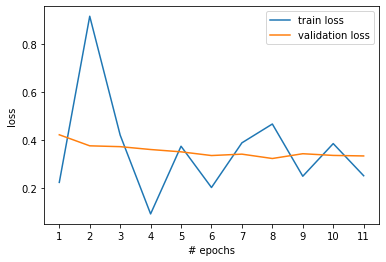

In [ ]:
plot(train_losses, val_losses)

In [ ]:
train_acc = inference(early_stopping_model, train_loader)
print_acc(train_acc)

  0%|          | 0/782 [00:00<?, ?it/s]

Train Accuracy: 90.62%


In [ ]:
test_acc = inference(early_stopping_model, test_loader)
print_acc(test_acc)

  0%|          | 0/157 [00:00<?, ?it/s]

Train Accuracy: 86.56%


#BatchNormalization

In [ ]:
class MLP_BatchNorm(nn.Module):
    def __init__(self, input_size: int, n_classes: int) -> None:
        super(MLP_BatchNorm, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 10)
        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(128)
        self.bn_3 = nn.BatchNorm1d(256)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn_1(x)
        x = F.relu(self.fc2(x))
        x = self.bn_2(x)
        x = F.relu(self.fc3(x))
        x = self.bn_3(x)
        x = self.fc4(x)
        return x

In [ ]:
batchnorm_model = MLP_BatchNorm(input_size, num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(batchnorm_model.parameters(), lr=learning_rate)

In [ ]:
train_losses, val_losses = training(
    batchnorm_model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.65, Validation Loss: 0.42


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.69, Validation Loss: 0.39


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.65, Validation Loss: 0.39


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.52, Validation Loss: 0.38


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.51, Validation Loss: 0.37


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.45, Validation Loss: 0.36


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.43, Validation Loss: 0.36


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.47, Validation Loss: 0.35


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.44, Validation Loss: 0.35


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.41, Validation Loss: 0.35


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.38, Validation Loss: 0.35


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.36, Validation Loss: 0.35


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.34, Validation Loss: 0.35


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.32, Validation Loss: 0.35


Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.31, Validation Loss: 0.35


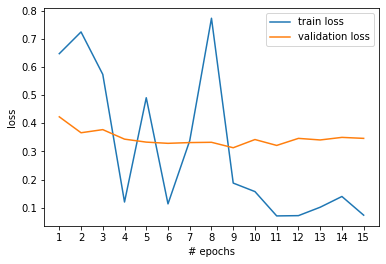

In [ ]:
plot(train_losses, val_losses)

In [ ]:
train_acc = inference(batchnorm_model, train_loader)
print_acc(train_acc)

  0%|          | 0/782 [00:00<?, ?it/s]

Train Accuracy: 92.89%


In [ ]:
test_acc = inference(batchnorm_model, test_loader)
print_acc(test_acc)

  0%|          | 0/157 [00:00<?, ?it/s]

Train Accuracy: 88.46%


#Add Regularization

In [22]:
def training_with_regularization(
    model: torch.nn.modules.module,
    train_dataset: torch.utils.data.dataloader,
    val_dataset: torch.utils.data.dataloader,
    criterion: torch.nn.modules.loss,
    optimizer: torch.optim,
    norm: str,
    lmbda: float = 0.01,
    epochs: int = 5,
) -> tuple:

    """
    train model with regularization
    return train and validation losses
    """

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs)):

        for data, targets in tqdm(train_dataset, desc=f"Epoch {epoch + 1}"):
            # convert data and target to device
            data = data.to(device)
            targets = targets.to(device)
            # flatten data to shape 28* 28
            data = data.reshape(data.shape[0], -1)

            # forward pass
            scores = model(data)
            loss = criterion(scores, targets)
            if norm == "l1":
                l1_reg = 0
                for param in model.parameters():
                    l1_reg += torch.norm(param, p=1)
                loss += lmbda * l1_reg
            if norm == "l2":
                l2_reg = 0
                for param in model.parameters():
                    l2_reg += torch.norm(param, p=2)
                loss += lmbda * l2_reg

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()

        # validation
        val_loss = validation(model, val_dataset, criterion)
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        print(f"Train Loss: {np.mean(train_losses):.2f}, ", end="")
        print(f"Validation Loss: {np.mean(val_losses):.2f}")
    return train_losses, val_losses

##L1 Regularization

In [ ]:
l1_reg_model = BiggerMLP(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(l1_reg_model.parameters(), lr=learning_rate)

In [ ]:
train_losses, val_losses = training_with_regularization(
    l1_reg_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    norm="l1",
    lmbda=0.001,
    epochs=EPOCHS,
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.92, Validation Loss: 0.76


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.00, Validation Loss: 0.68


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.04, Validation Loss: 0.64


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.92, Validation Loss: 0.63


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.93, Validation Loss: 0.61


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.96, Validation Loss: 0.60


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.95, Validation Loss: 0.59


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.97, Validation Loss: 0.58


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.03, Validation Loss: 0.58


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.96, Validation Loss: 0.57


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.97, Validation Loss: 0.56


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.93, Validation Loss: 0.56


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.91, Validation Loss: 0.56


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.90, Validation Loss: 0.55


Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.88, Validation Loss: 0.55


In [ ]:
train_acc = inference(l1_reg_model, train_loader)
print_acc(train_acc)

  0%|          | 0/782 [00:00<?, ?it/s]

Train Accuracy: 83.73%


In [ ]:
test_acc = inference(l1_reg_model, test_loader)
print_acc(test_acc)

  0%|          | 0/157 [00:00<?, ?it/s]

Train Accuracy: 82.43%


##L2 Regularization

In [ ]:
l2_reg_model = BiggerMLP(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(l2_reg_model.parameters(), lr=learning_rate)

In [ ]:
train_losses, val_losses = training_with_regularization(
    l2_reg_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    norm="l2",
    lmbda=0.001,
    epochs=EPOCHS,
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.45, Validation Loss: 0.47


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.48, Validation Loss: 0.42


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.41, Validation Loss: 0.41


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.48, Validation Loss: 0.40


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.49, Validation Loss: 0.39


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.42, Validation Loss: 0.38


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.43, Validation Loss: 0.37


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.43, Validation Loss: 0.36


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.43, Validation Loss: 0.36


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.42, Validation Loss: 0.36


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.42, Validation Loss: 0.36


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.44, Validation Loss: 0.35


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.43, Validation Loss: 0.35


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.42, Validation Loss: 0.35


Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.41, Validation Loss: 0.35


In [ ]:
train_acc = inference(l2_reg_model, train_loader)
print_acc(train_acc)

  0%|          | 0/782 [00:00<?, ?it/s]

Train Accuracy: 91.66%


In [ ]:
test_acc = inference(l2_reg_model, test_loader)
print_acc(test_acc)

  0%|          | 0/157 [00:00<?, ?it/s]

Train Accuracy: 87.73%


##L2 Regularization by weight decay

In [ ]:
l2_model = BiggerMLP(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(l2_model.parameters(), lr=learning_rate, weight_decay=0.001)

In [ ]:
train_losses, val_losses = training(
    l2_model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.36, Validation Loss: 0.47


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.30, Validation Loss: 0.45


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.31, Validation Loss: 0.43


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.29, Validation Loss: 0.42


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.33, Validation Loss: 0.41


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.37, Validation Loss: 0.40


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.37, Validation Loss: 0.39


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.39, Validation Loss: 0.39


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.35, Validation Loss: 0.38


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.36, Validation Loss: 0.38


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.37, Validation Loss: 0.38


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.35, Validation Loss: 0.38


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.34, Validation Loss: 0.38


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.35, Validation Loss: 0.37


Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.34, Validation Loss: 0.37


In [ ]:
train_acc = inference(l2_model, train_loader)
print_acc(train_acc)

  0%|          | 0/782 [00:00<?, ?it/s]

Train Accuracy: 89.89%


In [ ]:
test_acc = inference(l2_model, test_loader)
print_acc(test_acc)

  0%|          | 0/157 [00:00<?, ?it/s]

Train Accuracy: 86.86%
